In [5]:
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
import json

The following definitions are valid to pixels that are irradiated by the source exit port. 
The measurement equation is used to model the response of a sensor (DN) as a function of source configuration. 
Let $I$ denote the pixel response in DN. The pixel response $I$ should be expressed in matrix form, since the sensor is 2D array. But for simplicity, $I$ is expressed as a scalar. 

When the camera is assumed to be linear, there is sensor gain factor $K$ with units [DN/electrons] which converts electrons into DN. Let $A_{\rm s}$ be the source area and ${\omega}_{\rm s}$ be the solid angle subtended by the sensor entrance pupil at the source. Let $\lambda$ and $\Lambda$  be the optical wavelength and spectral band, respectively. 
Let ${L}_{\lambda}$ be the source spectral radiance which is known.
Let $\mathrm{QE}_{\lambda}$ and $\tau_{\lambda}\in[0,1]$ be the quantum efficiency and optical efficiency of the payload, respectively as defined in Sec.~\ref{chap:spect_range}.
Let $\Delta t$ be the exposure time. Denote speed of light and Plank's constant by $c$ and $h$, respectively.
Consider a pixel on the optical axis of the camera. The general form of the measurement equation for that pixel is 
\begin{equation}
\label{eq:measurement_equation}
    I = K {\Delta t} \; \int_{\Lambda} \int_{A_{\rm s}} \int_{\rm hemisphere} 
    {L}_{\lambda}\; {R}_{\lambda}\;{\rm d}A_{\rm s} \;{\rm d}{\omega}_{\rm s}\;{\rm cos}(\theta)\; {\rm d}\lambda \;\;\;\; [{\rm DN}].
\end{equation}

(2048, 2448)

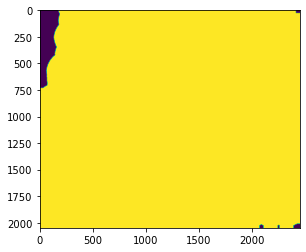

In [22]:
cam_id = 101936
cover = np.load(f"cover_{cam_id}.npy")
with open(f"{cam_id}_calibration_params.json", "rb") as file:
    param_dict = json.load(file)
    cover_fix = np.array(param_dict["fixer image"])
    dark_cover = np.array(param_dict["I_dark"])
    exposure_time = param_dict["exposure time"]
    integrating_sphere_DN = param_dict["integrating sphere DN"]
cover = (cover - dark_cover)*cover_fix
plt.imshow(cover)
cover.shape

In [23]:
h = 6.62607004e-34 #J*s is the Planck constant
c = 3.0e8 #m/s speed of litght

def interplolate(df, new_wav):
    """
     Inputs:
    pandas df containing different wavelength columns 
    new wav - new wavelength
    returns:
     pandas df with lambda and qe columns (same as before just different names)
     but with the same amount of values as the wavs vector
    """
    wavs = df.columns[1:]
    for i,w in enumerate(wavs):
        if new_wav < int(w):
            lower = int(wavs[i-1])
            upper = int(w)
            break
    coef = (new_wav - lower)/(upper - lower)
    df[str(new_wav)] = coef*df[str(upper)] + (1-coef)*df[str(lower)]
    return df

def rearange_qe_df(df, wavs):
    """
     Inputs:
    pandas df containing <wavelength [nm]> and <efficiency> columns 
    wavs - vector containing wavelength values (longer than the df column)
    returns:
     pandas df with lambda and qe columns (same as before just different names)
     but with the same amount of values as the wavs vector
    """
    new_df = {"lambda" : [], "qe": []}
    for wav in wavs:
        if (wav*1000) < 400 or (wav*1000) >850:
                continue
        for index, row in df.iterrows():
            if wav*1000 < row["<wavelength [nm]>"]:
                lower = df["<wavelength [nm]>"][index-1]
                upper = row["<wavelength [nm]>"]
                lower_qe = df["<efficiency>"][index-1]
                upper_qe = row["<efficiency>"]
                break
        coef = (wav*1000 - lower)/(upper - lower)
        qe = coef*upper_qe + (1-coef)*lower_qe
        new_df["lambda"].append(wav)
        new_df["qe"].append(qe)
        
    return pd.DataFrame.from_dict(new_df)



where ${R}_{\lambda}$ is the {\em absolute spectral responsivity} which consists of all the wavelength sensitive elements except of the spectral radiance ${L}_{\lambda}$,
\begin{equation}
\label{eq:spectral_responsivity}
    {R}_{\lambda} = \tau_{\lambda}\; \mathrm{QE}_{\lambda}\; \frac{\lambda}{hc} \;\;\;\; [\frac{\rm electrons}{\rm Joules}].
\end{equation}

In [24]:
mono_df = pd.read_csv("mono.csv", "\t")
empty = pd.read_csv("empty.csv")
mono_df = rearange_qe_df(mono_df, empty["lambda"])
R_lambda = (1e-9*mono_df["lambda"]*(mono_df["qe"]/100))/(h*c) # fixed units
mono_df

,lambda,qe
0,0.4003,26.5479
1,0.4008,26.7944
2,0.4013,27.0409
3,0.4018,27.2874
4,0.4023,27.5339
...,...,...
995,0.8482,13.3330
996,0.8486,13.2790
997,0.8490,13.2250
998,0.8494,13.1710


<AxesSubplot:>

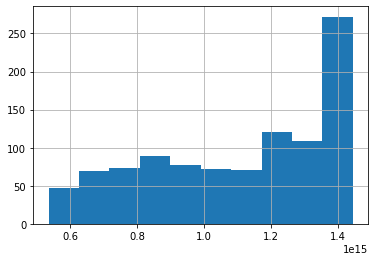

In [25]:
R_lambda.hist()

 it  is  common  to  use  system  relative  spectral  responsivity  (unitless)  which  is  defined  as following
\begin{equation}
\label{eq:eta}
    \eta_{\lambda} = \frac{{R}_{\lambda}}{{\rm max}\big\{ {R}_{\lambda} \big\}},
\end{equation}

In [26]:
eta_lambda = np.array(R_lambda/np.max(R_lambda))
eta_lambda.shape

(1000,)

where the term ${{\rm max}\big\{ {R}_{\lambda} \big\}}$ is the peak system spectral responsivity over the bandwidth $\Lambda$. Then, to use  normalized effective spectral radiometric terms. Let ${L}_{\rm eff}$ be the normalized effective radiance, 
\begin{equation}
\label{eq:L_eff}
    {L}_{\rm eff} = \int_{\Lambda} {L}_{\lambda} \, \eta_{\lambda} \, {\rm d}\lambda \;\;\;\; \big[  \frac{\rm W}{{\rm m}^2 \; {\rm sr}} \big].
\end{equation}

5068.739299234393
3057.536623639142


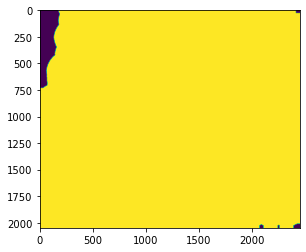

In [31]:
empty = pd.read_csv("empty.csv")
empty = interplolate(empty, integrating_sphere_DN)
empty = empty[(empty["lambda"]>0.4) & (empty["lambda"]<0.850)]
L_lambda = np.array(empty[f"{integrating_sphere_DN}"])
L_eff = np.trapz(L_lambda*eta_lambda, x=empty["lambda"])
C = np.mean(cover[cover>500])/(exposure_time*L_eff)
print(C)
print(np.mean(cover))
plt.imshow(cover)
plt.show()



In [28]:
param_dict["C"] = C

In [29]:
with open(f"{cam_id}_calibration_params.json", "w") as file:
    json.dump(param_dict, file)

## sanity check : for different DN values we get the same C

In [33]:
linear_check = {3000 : np.load("linear check 3000.npy"),
               3600 : np.load("linear check 3600.npy"),
               4200 : np.load("linear check 4200.npy"),
               5000 : np.load("linear check 5000.npy")}
for k,v in linear_check.items():
    print(k)
    v= v-dark
    v = v[v>100]
    print(np.mean(v))


3000


NameError: name 'dark' is not defined

In [86]:
mono_df = pd.read_csv("mono.csv", "\t")
empty = pd.read_csv("empty.csv")
mono_df = rearange_qe_df(mono_df, empty["lambda"])
R_lambda = (1e-9*mono_df["lambda"]*(mono_df["qe"]/100))/(h*c) # fixed units
mono_df

,lambda,qe
0,0.4003,26.5479
1,0.4008,26.7944
2,0.4013,27.0409
3,0.4018,27.2874
4,0.4023,27.5339
...,...,...
995,0.8482,13.3330
996,0.8486,13.2790
997,0.8490,13.2250
998,0.8494,13.1710


In [88]:
eta_lambda = np.array(R_lambda/np.max(R_lambda))
eta_lambda.shape

(1000,)

5470.021688286696
3000
2011.9530723871158


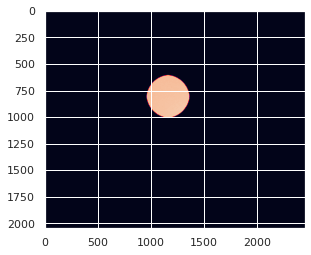

5509.297686112488
3600
2434.388348374543


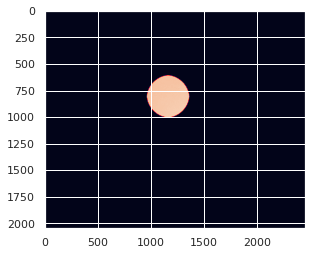

5491.947849159312
4200
2833.426152055132


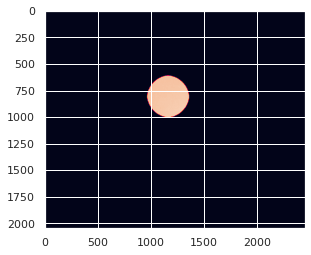

5536.02253526438
5000
3402.7894544390815


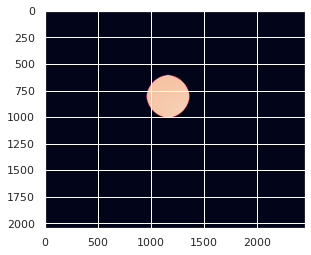

In [93]:
pts = []
exposure_time = 3000
for val,cover in linear_check.items():
    empty = pd.read_csv("empty.csv")
    empty = interplolate(empty, val)
    empty = empty[(empty["lambda"]>0.4) & (empty["lambda"]<0.850)]
    L_lambda = np.array(empty[f"{val}"])
    L_eff = np.trapz(L_lambda*eta_lambda, x=empty["lambda"])
    C = np.mean(cover[cover>500])/(exposure_time*L_eff)
    print(C)
    print(val)
    print(np.mean(cover[cover>500]))
    pts.append((val,C))
    plt.imshow(cover)
    plt.show()

